In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
fail_threshold = 0.0033
deep_dchi2 = 100
mindepth = 120

total number, total deep, min depth for deep
182043 27012 9356.199974060059
number of unique targets is 26051
34350
number, fraction of failures, fraction of failures with zwarn==0
25742 0.1468417372387538 0.08309377670732655


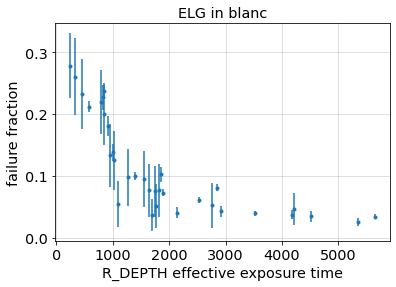

In [7]:
tp = 'ELG'
release = 'blanc'

f = fitsio.read('/project/projectdirs/desi/users/ajross/catalogs/SV/redshift_comps/'+release+'/v0/'+tp+'/alltiles_'+tp+'zinfo.fits') #fitsio *much* faster than using Table here
deep = f[f['subset']=='deep'] 
min_depth = np.max(deep['R_DEPTH'])/2

print('total number, total deep, min depth for deep')
print(len(f),len(deep),min_depth)
#get list of truez in appropriate rows, matching Rongpu's definition for criteria required to allow truth determination
#rows without truth have z==0
mzl = np.zeros(len(f))
tids = np.unique(f['TARGETID'])
print('number of unique targets is '+str(len(tids)))
for iid in tids:
    sf = f['TARGETID'] == iid
    fi = f[sf]
    fd = fi[fi['subset']=='deep']
    mask = fd['FIBERSTATUS']==0 # Remove FIBERSTATUS!=0 fibers
    mask &= fd['ZWARN'] & 2**9==0 # Remove "no data" fibers
    mask &= fd['ZWARN']==0
    mask &= fd['R_DEPTH'] > min_depth
    mask &= fd['DELTACHI2'] > deep_dchi2
    if len(fd[mask]) > 0:
        mzl[sf] = fd['Z'][0]

w = mzl != 0
print(len(mzl[w]))
tf = Table(f)
tf['Z_TRUTH'] = mzl
masknight = tf['subset'] != 'deep'
masknight &= tf['subset'] != 'all'
masknight &= tf['Z_TRUTH'] != 0
masknight &= tf['FIBERSTATUS']==0
masknight &= tf['ZWARN'] & 2**9==0
tcomp = tf[masknight]
dz = tcomp['Z'] - tcomp['Z_TRUTH']
bz = abs(dz) > fail_threshold
bzz = bz & (tcomp['ZWARN'] != 0)
print('number, fraction of failures, fraction of failures with zwarn==0')
print(len(tcomp),len(tcomp[bz])/len(tcomp),len(tcomp[bzz])/len(tcomp))
rvals = np.unique(tcomp['R_DEPTH'])
ff = []
rv = []
nb = []
nt = []
for rval in rvals:
    ds = tcomp[tcomp['R_DEPTH']==rval]
    dz = ds['Z'] - ds['Z_TRUTH']
    bz = abs(dz) > fail_threshold
    if len(ds) > 30 and rval > mindepth:
        ff.append(len(ds[bz])/len(ds))
        nb.append(len(ds[bz]))
        nt.append(len(ds))
        rv.append(rval)
nt = np.array(nt)
nb = np.array(nb)
err = ((nt-nb)*(1.-(nt-nb)/nt))**.5/nt #binomial error formula, needs double-check
plt.errorbar(rv,ff,err,fmt='.')#,label=td)

#plt.legend()
plt.grid(alpha=0.5)
plt.xlabel('R_DEPTH effective exposure time')
plt.ylabel('failure fraction')
plt.title(tp+' in '+release)
plt.show()